# Deflection Profile Parametric Study
This file presents a parametric study based on the Deflection-Profile implementation provided in the file "deflection_profile.py" of the bmcs_beam package.

In [1]:
%matplotlib inline

In [2]:
from bmcs_cross_section.mkappa import MKappa
from bmcs_beam.beam_config.boundary_conditions import BoundaryConditions
from bmcs_beam.bending.deflection_profile import DeflectionProfile
from bmcs_beam.beam_config.beam_design import BeamDesign
from bmcs_cross_section.cs_design.cs_shape import TShape
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu

In [3]:
def plot_parametric_study(ver_data):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(21,20), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        w = ver_data[0]
        f = ver_data[1]
        dp.plot_fw(ax)
        ax.plot(w, f, c= 'red', label= 'Experiment')
        parameters = ["l", "b", "h", "E", "E_s", "f_sy", "eps_cr", "rho",
              "beta_tu", "v_f", "omega", "psi", "mu", "alpha", "lambda_cu"]
        ax.set_title(parameters[i])
    plt.tight_layout()
    plt.show()

In [4]:
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape.B=b
    mc.cross_section_shape.H=h
    mc.E_cc=E
    mc.E_ct=E 
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.eps_sy_j=[f_sy / E_s] # or eps_sy_j=psi * eps_cr,
    mc.E_j=[E_s]
    mc.z_j=[h * (1 - alpha)]
    mc.A_j=[rho * b * h]

#### 1. Verification with Bielak (2019), https://doi.org/10.3390/app9071382, Carbon reinforcement

In [5]:
excel_file = join('./verification_data/Bie19','Bielak_2019.xlsx')
data = pd.read_excel(excel_file)

w_= data['C3-3-8-2_w']  ; f_= data['C3-3-8-2_F'] ; ver_data = [w_, f_];# plt.plot(w_,f_, label = 'C3-3-8-2')
w_1= data['C3-2-8-3_w']  ; f_1= data['C3-2-8-3_F'] ; ver_data1 = [w_1, f_1]; #plt.plot(w_1,f_1, label = 'C3-2-8-3')
w_2= data['C3-1-8-3_w']  ; f_2= data['C3-1-8-3_F'] ; ver_data2 = [w_2, f_2]; #plt.plot(w_2,f_2, label = 'C3-1-8-3')

#plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');

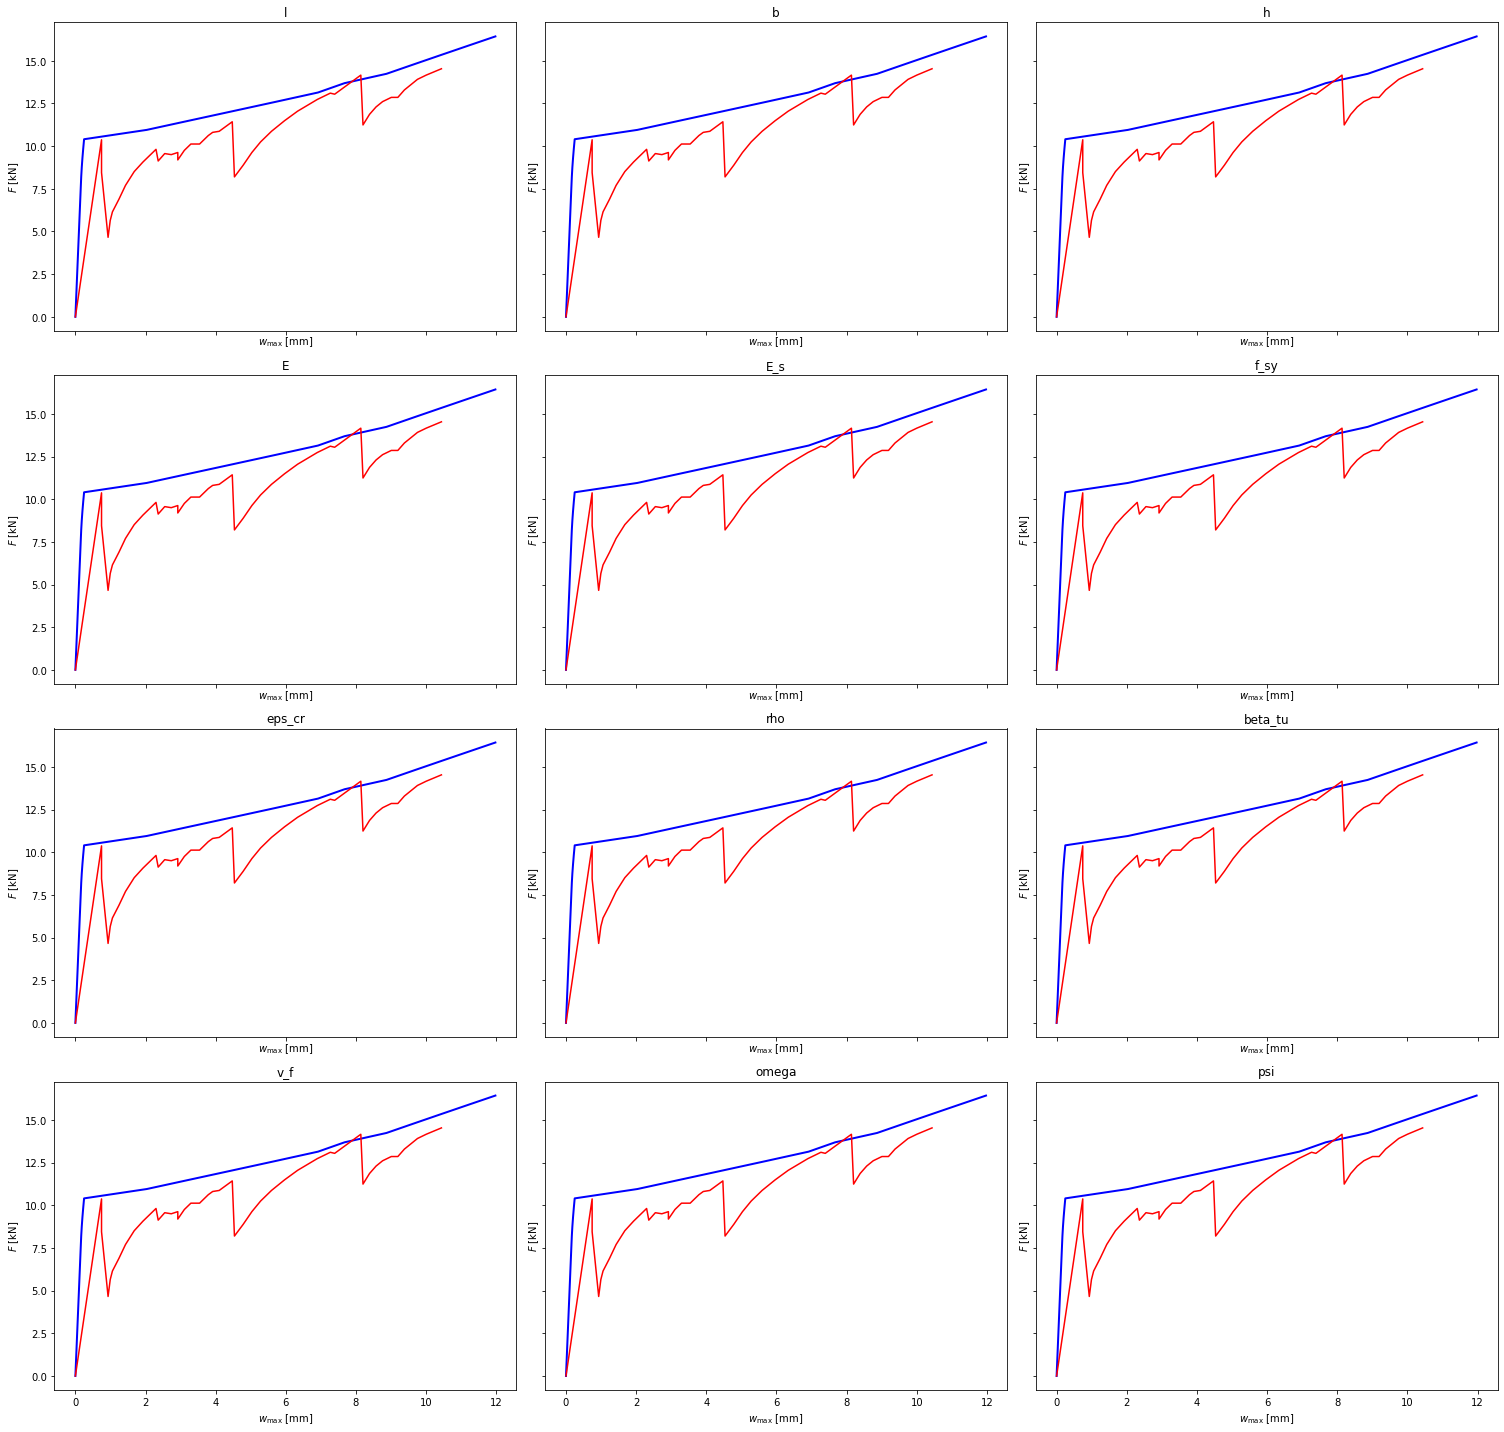

In [6]:
# C3-2-8-3
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0003
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

parameters = ["l", "b", "h", "E", "E_s", "f_sy", "eps_cr", "rho",
              "beta_tu", "v_f", "omega", "psi", "mu", "alpha", "lambda_cu"]

dp.beam_design.L = 2 * 400

map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2 ,  #  eps_tu/eps_cr
            b = 199 ,
            h = 100 ,
            rho = 0.00256 ,
            v_f = 0.0 ,
            E = 45346 * 0.7 ,
            E_s = 244835 * 0.2, #Warp:244835, Weft:243828
            f_sy = 3221, #Warp:3221, Weft:3334
            eps_cr = 0.0002616,
            omega = 0.28/0.2616, #eps_cy/eps_cr
            psi = 13.2/0.2616 , #eps_sy_j/eps_cr
            mu = 0.0, #σp/σcr
            alpha = 0.71, #z_j/h
            lambda_cu = 2.92/0.2616) #eps_cu/eps_cr

plot_parametric_study(ver_data1)